## Goal
Apply Kmeans and KMedoids on Amazon Food reviews
1. Featurize/Vectorize - BoW, tfIDF, Average Word2Vec, tfIDF Word2Vec
2. Train/Test split using time based slicing as a 70-30 split
3. Remove y_i_s.
4. Run KMeans for different K and find optimal K using elbow method.
5. Read reviews from each cluster to get an understanding of how each reviews in the same cluster are related.


### Data
The Amazon fine food reviews dataset is available [here](https://www.kaggle.com/snap/amazon-fine-food-reviews/downloads/database.sqlite/2). The SQLLite version(database.sqlite) of the dataset is used. A folder called 'amazon-fine-food-reviews' needs to be created in the working directory and downloaded to that folder.

Google Word2Vec (GoogleNews-vectors-negative300.bin) is also used and those are available [here](https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
pd.options.display.max_colwidth = 20000
import KMedoids
from sklearn.metrics import pairwise_distances
from wordcloud import WordCloud, STOPWORDS


from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer, CountVectorizer
from sklearn.metrics import confusion_matrix, f1_score, classification_report, make_scorer, roc_curve, auc
from sklearn import metrics
from sklearn.decomposition import TruncatedSVD

import itertools, pickle, random, sqlite3, nltk, string, re
from pathlib import Path
from scipy import sparse
import scipy as sp

import warnings
warnings.filterwarnings("ignore")

import seaborn as sns
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec, KeyedVectors
from tqdm import tqdm
from datetime import datetime, timedelta

d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


### Load Data

In [3]:
# using the SQLite Table to read data.
con = sqlite3.connect('./amazon-fine-food-reviews/database.sqlite') 

#filtering only positive and negative reviews i.e. 
# not considering those reviews with Score=3
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 

In [4]:
# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

#change reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print ('Total number of reviews is {} with {} features each'.format(*filtered_data.shape))
filtered_data.head()

Total number of reviews is 525814 with 10 features each


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


### EDA

#### Remove Duplicates

In [5]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)

#### Data Cleanup

In [6]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


positive    307061
negative     57110
Name: Score, dtype: int64

#### Note:
The dataset is imbalanced. So the metric to evaluate the model should not be accuracy, it could be confusion matrix 

### PreProcessing

#### Stemming, Stop word remove and Lemmatization

In [7]:
stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print('The stop words are \n {}'.format(stop))
print('************************************************************')
print('The stem word for tasty is {}'.format(sno.stem('tasty')))

The stop words are 
 {'this', 'myself', 'how', "shouldn't", 'any', 'no', 'o', 'be', 'of', 'with', 'does', 'me', "couldn't", 'because', 'off', 'which', 'doesn', 'that', 'each', 'we', "needn't", 'our', 'a', 'he', "doesn't", 'these', 'm', "won't", 'same', "isn't", 'themselves', 'such', 'both', 't', 'yours', 'wouldn', 'only', 'mightn', "you're", 'ours', 'did', 'most', "that'll", 'isn', 'own', "weren't", "don't", 'what', 'ourselves', 'there', 'it', 'against', 'you', 'if', "wasn't", 'is', 'why', 'are', 'out', 'theirs', 'mustn', 'needn', 'ain', "shan't", 'should', 'by', 'his', 'who', 'am', 'my', 'about', 'below', 'more', 'ma', 'while', 'her', 'those', 'here', 'or', 'shouldn', 'other', 'll', 'some', 'before', "should've", 'd', 'to', 'couldn', 'then', 'whom', 'your', 'over', 'himself', 'him', 'in', 'into', 'as', 'were', 're', 'few', 'further', 'shan', 'up', 'under', "mustn't", 'until', "she's", 'than', 'aren', 'weren', 'hers', 'has', 'once', 'all', 'now', 'having', 'they', 'on', 'when', 'the', 

We need 3 types of cleaned data so we will use 3 different variables to store this data:
1. For Bag of Words and TfIDF we need the stop words to be removed and stemmed
2. For Bigrams and trigrams we do not need to remove the stop words but we can stem the words
3. For Avg Word2Vec and TfIDF Word2Vec we can remove the stopwords but not stem the words if we plan to use Google's word2vec model.

In [10]:
i=0
str_b=' '
str_n=' '
str_w=' '
bow_tfidf_string=[]
ngrams_string=[]
word2vec_string=[]
s=''
for sent in final['Text'].values:
    filtered_sentence_b=[]
    filtered_sentence_n=[]
    filtered_sentence_w=[]
    
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)): 
                s=(sno.stem(cleaned_words.lower())).encode('utf8')
                filtered_sentence_n.append(s) #for ngrams we need stemmed words
                if(cleaned_words.lower() not in stop):
                    filtered_sentence_b.append(s) #for BoW and tfidf we need stemmed and stop words removed data
                    filtered_sentence_w.append(cleaned_words.lower().encode('utf8')) # for Word2Vec we need non stemmed and stop words removed data
                else:
                    continue
            else:
                continue 
    
    
    str_n = b" ".join(filtered_sentence_n)
    str_b = b" ".join(filtered_sentence_b)
    str_w = b" ".join(filtered_sentence_w)
    
    bow_tfidf_string.append(str_b)
    ngrams_string.append(str_n)
    word2vec_string.append(str_w)

    i+=1

In [11]:
final['BowTfIDFText']=bow_tfidf_string 
final['BowTfIDFText']=final['BowTfIDFText'].str.decode("utf-8")

# final['nGramsText']=ngrams_string 
# final['nGramsText']=final['nGramsText'].str.decode("utf-8")

final['Word2VecText']=word2vec_string 
final['Word2VecText']=final['Word2VecText'].str.decode("utf-8")

In [12]:
# store final table into an SQlLite table for future.
final_dbconn = sqlite3.connect('./amazon-fine-food-reviews/finaldb.sqlite')
c=final_dbconn.cursor()
final_dbconn.text_factory = str
final.to_sql('Reviews', final_dbconn,  schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)

### Run Classifier

In [2]:
def plot_word_cloud(file_name, title, word_cloud_column):
    if not file_name or not title or not word_cloud_column:
        print ('file_name, title and word_cloud_column are mandatory parameters')
        return
    
    df = pd.read_csv(file_name, encoding ="latin-1") 

    comment_words = ' '
    stopwords = set(STOPWORDS) 

    for i in range(df.ClusterID.nunique()):
        wordcloud = WordCloud(width = 800, height = 800, 
                        background_color ='white', 
                        stopwords = stopwords, 
                        min_font_size = 10).generate(str(df[df.ClusterID == i][word_cloud_column])) 

        # plot the WordCloud image                        
        plt.figure(figsize = (8, 8), facecolor = None) 
        plt.title(title + ' ' + str(i))
        plt.imshow(wordcloud) 
        plt.axis("off") 
        plt.tight_layout(pad = 0) 

        plt.show() 

In [2]:
def plot_elbow(K, sse):
    # Plot the elbow
    plt.plot(K, sse, 'bx-')
    
    plt.xlabel('k')
    plt.ylabel('Sum of distances of samples to their closest cluster center')

    plt.title('The Elbow Method showing the optimal k')
    plt.grid()
    
    plt.show()

In [3]:
def save_metoids_to_file(M, C, metoid_file_name, clusters_file_name):
#     Saving Metoids to file
    print ('Saving Metoids to file......')
    metoids_met_arr = dict()
    cnt = 0
    for i in M:
        metoids_met_arr[cnt]= [i, data[i: i+1]['Text'].to_string(index=False), data[i: i+1]['Score'].to_string(index=False)]
        cnt = cnt + 1
    csv_file_name = metoid_file_name
    metoids_df = pd.DataFrame.from_dict(metoids_met_arr, orient='index', columns=['ReviewID', 'Text', 'Score'])
    metoids_df.to_csv(csv_file_name, index=False)

    # Saving Metoid Clusters to file
    print ('Saving Metoid Clusters to file......')
    metoids_data_arr = dict()
    cnt = 0
    for cluster in C:
        for i in C[cluster]:
            metoids_data_arr[cnt] = [cluster, i, data[i: i+1]['Text'].to_string(index=False), data[i: i+1]['Score'].to_string(index=False)]
    #         print('Cluster {0}:　{1}'.format(cluster, data[i:i+1][['Text', 'Score']]))
            cnt = cnt + 1
    csv_file_name = clusters_file_name
    metoids_df = pd.DataFrame.from_dict(metoids_data_arr, orient='index', columns=['Cluster', 'ReviewID', 'Text', 'Score'])
    metoids_df.to_csv(csv_file_name, index=False)

In [11]:
def model_using_metoids(X, k, metoid_file_name, clusters_file_name):
    # distance matrix
    print ('Creating pairwise distance.....')
    D = pairwise_distances(X, metric='euclidean')

    print ('Clustering using KMedoids.....')
    # split into optimal_k clusters
    M, C = KMedoids.kMedoids(D, k)

    save_metoids_to_file(M, C, metoid_file_name, clusters_file_name)

In [5]:
def run_classifier(data, vectorize_technique):
    if vectorize_technique not in ['bow', 'tfidf', 'Gavgw2v', 'Gtfidfw2v', 'Oavgw2v', 'Otfidfw2v']:
        print ('Allowed vectorization techniques are Bag Of Words(bow), TF-IDF(tfidf), \
                Average Word2Vec Using Google vectors(Gavgw2v), TF-IDF Word2Vec Using Google vectors(Gtfidfw2v), \
                Average Word2Vec Using Own Model(Oavgw2v), TF-IDF Word2Vec Using Own Model(Otfidfw2v)')
        return
    
    #Create X_train with just the vectors
    if vectorize_technique == 'bow':
        X, vectorizer = vectorize_bow(data)
    elif vectorize_technique == 'tfidf':
        X, vectorizer = vectorize_tfidf(data)
    elif vectorize_technique == 'Gavgw2v':
        X = vectorize_Gavgw2v(data)
    elif vectorize_technique == 'Gtfidfw2v':
        X = vectorize_Gavgw2v(data)
    elif vectorize_technique == 'Oavgw2v':
        X = vectorize_Oavgw2v(data)
    elif vectorize_technique == 'Otfidfw2v':
        X = vectorize_Otfidfw2v(data)
        
    if len(data) <= 5:
        Ks = range (1,3)
    else:
        Ks = range(1,10)
    sse = []
    
    for k in Ks:
        model = KMeans(n_clusters=k, n_jobs=-1).fit(X)
        sse.append(model.inertia_)
            
    plot_elbow(Ks, sse)
    return X

## Bag of Words

In [6]:
def get_bow_tfidfdata(no_of_records = 2000, split_evenly=True):
    if split_evenly:
        pos_limit = int(no_of_records * 0.50)
        neg_limit = no_of_records - pos_limit
    else:
    #The original dataset has approximately 85% positive reviews and 15% negative reviews, so we will use the same % to make
    #a subset 
        pos_limit = int(no_of_records * 0.85)
        neg_limit = no_of_records - pos_limit

    final_dbconn = sqlite3.connect('./amazon-fine-food-reviews/finaldb.sqlite')
    final_dbconn.text_factory = str

    pos_qry = "SELECT Text, BowTfIDFText, Score FROM Reviews where Score = 'positive' LIMIT " + str(pos_limit)
    pos_reviews = pd.read_sql_query(pos_qry, final_dbconn) 
    print('Positive reviews shape is {}'.format(pos_reviews.shape))

    neg_qry = "SELECT Text, BowTfIDFText, Score FROM Reviews where Score = 'negative' LIMIT " + str(neg_limit)
    neg_reviews = pd.read_sql_query(neg_qry, final_dbconn) 
    print('Negative reviews shape is {}'.format(neg_reviews.shape))

    frames = [pos_reviews, neg_reviews]

    data = pd.concat(frames, ignore_index=True)
    print('Both positive and negative reviews combined together contains {} reviews'.format(data.shape[0]))
    return data

In [7]:
def vectorize_bow(X):
    #Vectorize the reviews
    count_vect = CountVectorizer() 
    
    #Build vocabulary from X_train
    X_counts = count_vect.fit_transform(X['BowTfIDFText'].values)
    
    print("Shape of vectorized dataset is {}".format(X_counts.get_shape()))
    print("Number of unique words in the dataset is ", X_counts.get_shape()[1])
    print ('Type of bow_counts ', type(X_counts))
    
    X_std_data = StandardScaler(with_mean = False).fit_transform(X_counts)
    print ('Type of std_bow_data is {}'.format(type(X_std_data)))
    print ('Standardized Bag of Words review contains {} records with {} features each'.format(*X_std_data.shape))

    return X_std_data, count_vect

10:30:50
Positive reviews shape is (25000, 3)
Negative reviews shape is (25000, 3)
Both positive and negative reviews combined together contains 50000 reviews
Shape of vectorized dataset is (50000, 29333)
Number of unique words in the dataset is  29333
Type of bow_counts  <class 'scipy.sparse.csr.csr_matrix'>


d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Type of std_bow_data is <class 'scipy.sparse.csr.csr_matrix'>
Standardized Bag of Words review contains 50000 records with 29333 features each


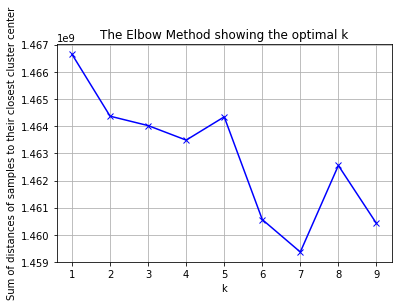

10:40:02


In [8]:
# no_of_records=364171
no_of_records=50000
print (format(datetime.now(), '%H:%M:%S'))
data = get_bow_tfidfdata(no_of_records)
X = run_classifier(data, vectorize_technique ='bow')

ist = datetime.now()
print (format(ist, '%H:%M:%S'))

In [9]:
csv_file_name = './amazon-fine-food-reviews/KMeansBoW.csv'
optimal_k = 4
model = KMeans(n_clusters=optimal_k, n_jobs=-1).fit(X)
data['ClusterID']=model.labels_ 
data.to_csv(csv_file_name, index=False)

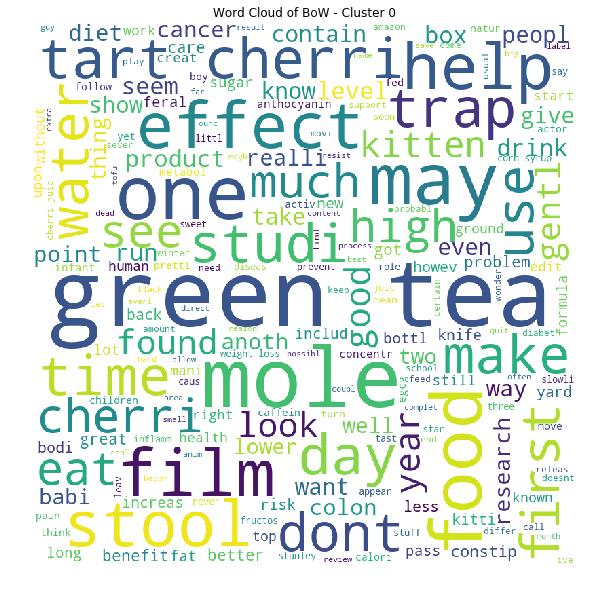

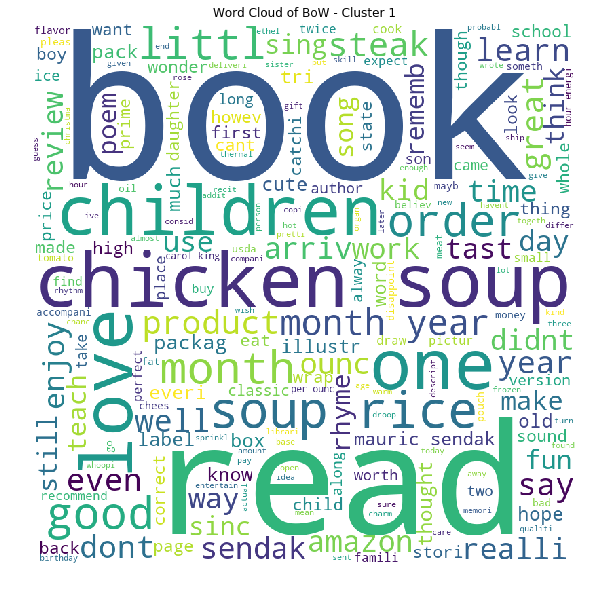

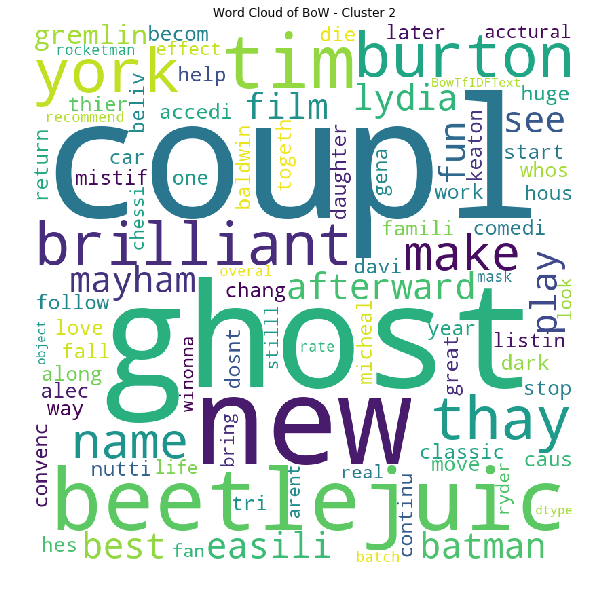

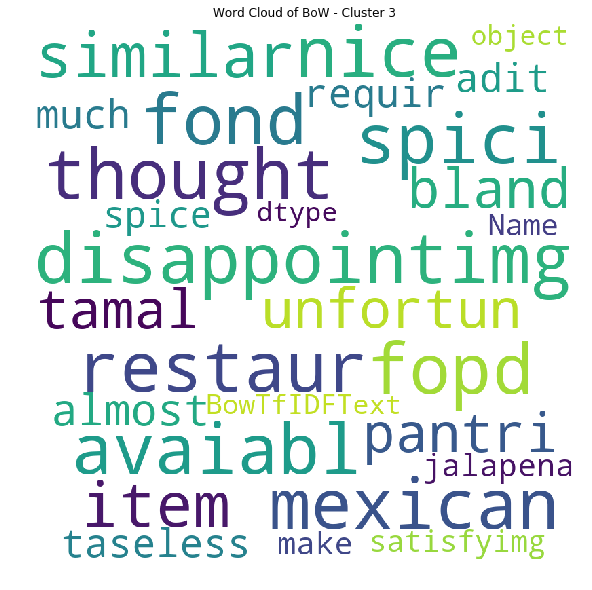

In [3]:
file_name='./amazon-fine-food-reviews/KMeansBoW.csv'
title='Word Cloud of BoW - Cluster'
word_cloud_column = 'BowTfIDFText'
plot_word_cloud(file_name, title, word_cloud_column)

In [10]:
metoid_file_name = './amazon-fine-food-reviews/MetoidsFromMetoids-BoW.csv'
clusters_file_name = './amazon-fine-food-reviews/ClusterFromMetoids-BoW.csv'
model_using_metoids(X, optimal_k, metoid_file_name, clusters_file_name)

Saving Metoids to file......
Saving Metoid Clusters to file......


## TF-IDF

In [12]:
def vectorize_tfidf(X):
    #Vectorize the reviews
    tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
    
    #Build vocabulary from X_train
    X_counts = tf_idf_vect.fit_transform(X['BowTfIDFText'].values)
        
    print("Shape of vectorized dataset is {}".format(X_counts.get_shape()))
    print("Number of unique words in the dataset is ", X_counts.get_shape()[1])
    print ('Type of bow_counts ', type(X_counts))
    
    X_std_data = StandardScaler(with_mean = False).fit_transform(X_counts)
    print ('Type of std_bow_data is {}'.format(type(X_std_data)))
    print ('Standardized Bag of Words review contains {} with {} features each'.format(*X_std_data.shape))
    
    return X_std_data, tf_idf_vect

11:20:09
Positive reviews shape is (25000, 3)
Negative reviews shape is (25000, 3)
Both positive and negative reviews combined together contains 50000 reviews
Shape of vectorized dataset is (50000, 828620)
Number of unique words in the dataset is  828620
Type of bow_counts  <class 'scipy.sparse.csr.csr_matrix'>
Type of std_bow_data is <class 'scipy.sparse.csr.csr_matrix'>
Standardized Bag of Words review contains 50000 with 828620 features each


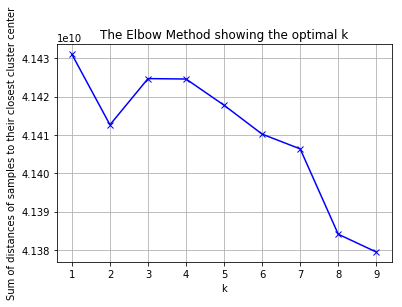

11:28:19


In [13]:
# no_of_records=364171
no_of_records=50000
print (format(datetime.now(), '%H:%M:%S'))
data = get_bow_tfidfdata(no_of_records)
X = run_classifier(data, vectorize_technique ='tfidf')
ist = datetime.now()
print (format(ist, '%H:%M:%S'))

In [15]:
csv_file_name = './amazon-fine-food-reviews/KMeansTfIdf.csv'
optimal_k = 2
model = KMeans(n_clusters=optimal_k, n_jobs=-1).fit(X)
data['ClusterID']=model.labels_ 
data.to_csv(csv_file_name, index=False)

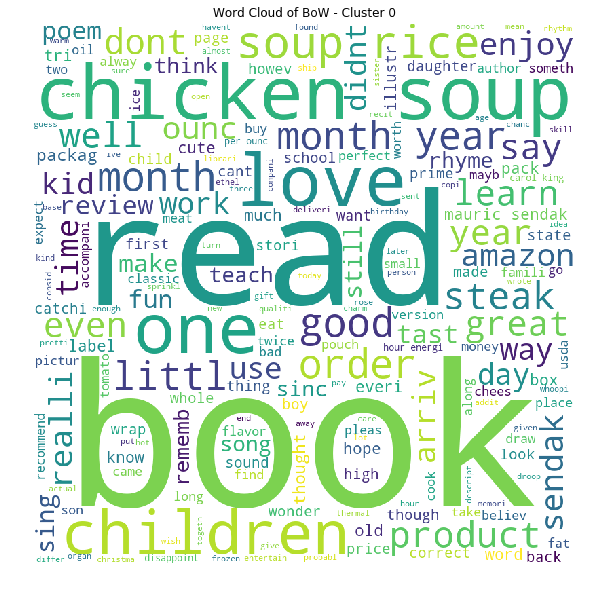

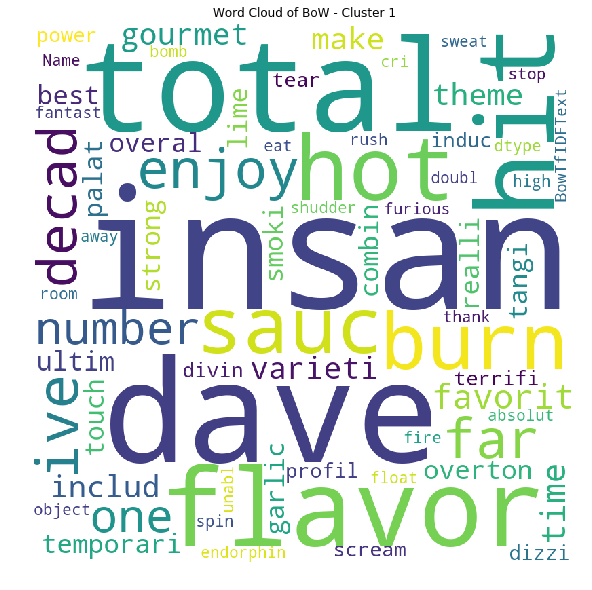

In [4]:
file_name='./amazon-fine-food-reviews/KMeansTfIdf.csv'
title='Word Cloud of BoW - Cluster'
word_cloud_column = 'BowTfIDFText'
plot_word_cloud(file_name, title, word_cloud_column)

In [16]:
print (format(datetime.now(), '%H:%M:%S'))
metoid_file_name = './amazon-fine-food-reviews/MetoidsFromMetoids-TfIDF.csv'
clusters_file_name = './amazon-fine-food-reviews/ClusterFromMetoids-TfIDF.csv'
model_using_metoids(X, optimal_k, metoid_file_name, clusters_file_name)
print (format(datetime.now(), '%H:%M:%S'))

11:32:08
Creating pairwise distance.....
Clustering using KMedoids.....
Saving Metoids to file......
Saving Metoid Clusters to file......
11:56:54


## Word2Vec
There are 2 ways to do word2vec
1. Use Google's model which was built using Google's news dataset. Since this was built from a large dataset, this gives us a 300 dimension vector which will be richer.
2. Train our own model. Since we have a small dataset, we can build a 50 dimensional vector with this.
We will try both ways below

As a first step we need to build a list of sentence from the Word2VecText we have saved earlier. This will be used to get the vectors from Google's model as well as the one that we are going to build

In [17]:
def get_w2vdata(no_of_records = 2000, split_evenly=True):
    if split_evenly:
        pos_limit = int(no_of_records * 0.50)
        neg_limit = no_of_records - pos_limit
    else:
    #The original dataset has approximately 85% positive reviews and 15% negative reviews, so we will use the same % to make
    #a subset 
        pos_limit = int(no_of_records * 0.85)
        neg_limit = no_of_records - pos_limit

    final_dbconn = sqlite3.connect('./amazon-fine-food-reviews/finaldb.sqlite')
    final_dbconn.text_factory = str

    pos_qry = "SELECT Text, Word2VecText, Score FROM Reviews where Score = 'positive' LIMIT " + str(pos_limit)
    pos_reviews = pd.read_sql_query(pos_qry, final_dbconn) 
    print('Positive reviews shape is {}'.format(pos_reviews.shape))

    neg_qry = "SELECT Text, Word2VecText, Score FROM Reviews where Score = 'negative' LIMIT " + str(neg_limit)
    neg_reviews = pd.read_sql_query(neg_qry, final_dbconn) 
    print('Negative reviews shape is {}'.format(neg_reviews.shape))

    frames = [pos_reviews, neg_reviews]

    data = pd.concat(frames, ignore_index=True)
    print('Both positive and negative reviews combined together contains {} reviews'.format(data.shape[0]))

    return data

#### Train our own Word2Vec model

In [18]:
def build_word2vec(train_list_of_sent):
    # Train your own Word2Vec model using your own text corpus
    w2v_model=Word2Vec(train_list_of_sent,min_count=5,size=50, workers=4)

    w2v_words = list(w2v_model.wv.vocab)
    return w2v_model, w2v_words

#### Average Word2Vec With our own model

In [19]:
def vectorize_Oavgw2v(X):
    list_of_sent=[]
    
    print ('Splitting data into sentences.....')
    for sent in X['Word2VecText'].values:
        list_of_sent.append(sent.split())
    
    print ('Building our word model.....')
    w2v_model, w2v_words = build_word2vec(list_of_sent)

    print ('Vectorizing train data.....')
    print('Starting vectorizing at {}'. format(datetime.now()))
    
    sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
    for sent in list_of_sent: # for each review/sentence
        sent_vec = np.zeros(50) # as word vectors are of zero length
        cnt_words =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_words:
                vec = w2v_model.wv[word]
                sent_vec += vec
                cnt_words += 1
        if cnt_words != 0:
            sent_vec /= cnt_words
        sent_vectors.append(sent_vec)

    print('Completed vectorizing at {}'. format(datetime.now()))
    
    #convert to sparse matrix
    X_counts = sparse.csr_matrix(np.array(sent_vectors))
            
    X_std_data = StandardScaler(with_mean = False).fit_transform(X_counts)
    print ('Type of std_bow_data is {}'.format(type(X_std_data)))
    print ('Standardized reviews contain {} reviews with {} features each'.format(*X_std_data.shape))
    
    return X_std_data

12:07:44
Positive reviews shape is (25000, 3)
Negative reviews shape is (25000, 3)
Both positive and negative reviews combined together contains 50000 reviews
Splitting data into sentences.....
Building our word model.....
Vectorizing train data.....
Starting vectorizing at 2018-11-12 12:08:27.928716
Completed vectorizing at 2018-11-12 12:09:35.264938
Type of std_bow_data is <class 'scipy.sparse.csr.csr_matrix'>
Standardized reviews contain 50000 reviews with 50 features each


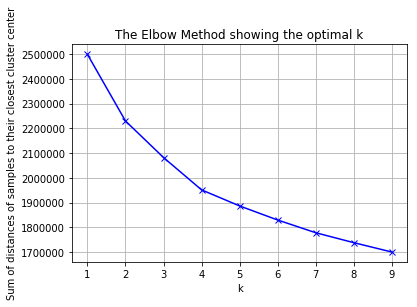

13:00:14


In [20]:
# no_of_records=364171
no_of_records=50000
print (format(datetime.now(), '%H:%M:%S'))
data = get_w2vdata(no_of_records)
X=run_classifier(data, vectorize_technique ='Oavgw2v')
ist = datetime.now()
print (format(ist, '%H:%M:%S'))

In [21]:
csv_file_name = './amazon-fine-food-reviews/KMeansAvgW2V.csv'
optimal_k = 4
model = KMeans(n_clusters=optimal_k, n_jobs=-1).fit(X)
data['ClusterID']=model.labels_ 
data.to_csv(csv_file_name, index=False)

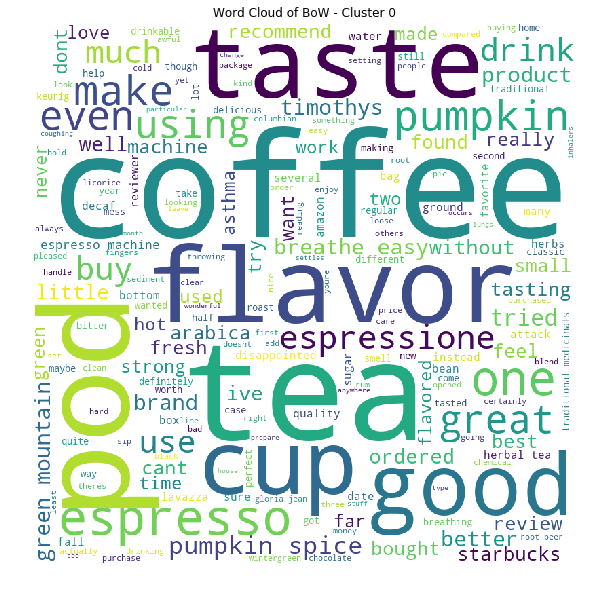

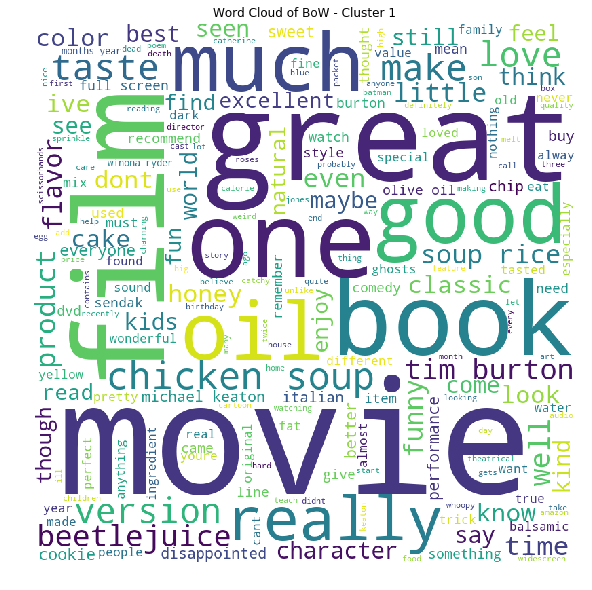

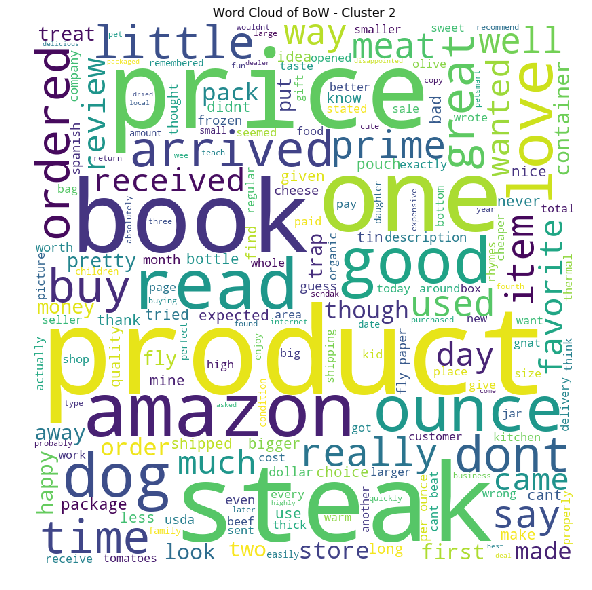

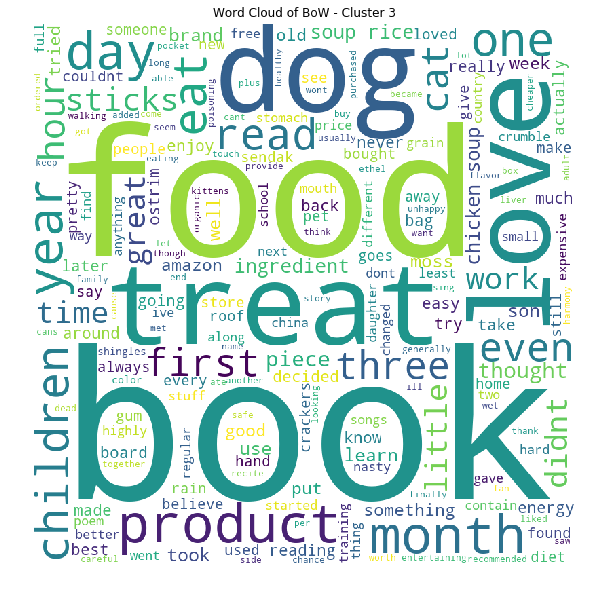

In [5]:
file_name='./amazon-fine-food-reviews/KMeansAvgW2V.csv'
title='Word Cloud of BoW - Cluster'
word_cloud_column = 'Word2VecText'
plot_word_cloud(file_name, title, word_cloud_column)

In [22]:
print (format(datetime.now(), '%H:%M:%S'))
metoid_file_name = './amazon-fine-food-reviews/MetoidsFromMetoids-AvgW2V.csv'
clusters_file_name = './amazon-fine-food-reviews/ClusterFromMetoids-AvgW2V.csv'
model_using_metoids(X, optimal_k, metoid_file_name, clusters_file_name)
print (format(datetime.now(), '%H:%M:%S'))

13:14:21
Creating pairwise distance.....
Clustering using KMedoids.....
Saving Metoids to file......
Saving Metoid Clusters to file......
13:49:03


#### TF-IDF weighted Word2Vec With our own model

In [23]:
def vectorize_Otfidfw2v(X):
    # TF-IDF weighted Word2Vec
    tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
    tf_idf_counts = tf_idf_vect.fit_transform(X['Word2VecText'].values)
    
    # we are converting a dictionary with word as a key, and the idf as a value
    dictionary = dict(zip(tf_idf_vect.get_feature_names(), list(tf_idf_vect.idf_)))


    tfidf_feat = tf_idf_vect.get_feature_names() 
    
    list_of_sent=[]
    
    print ('Splitting train data into sentences.....')
    for sent in X['Word2VecText'].values:
        list_of_sent.append(sent.split())
    
    print ('Building our word model.....')
    w2v_model, w2v_words = build_word2vec(list_of_sent)
    
    print ('Vectorizing data.....')
    sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
    row=0;
    for sent in list_of_sent: # for each review/sentence 
        sent_vec = np.zeros(50) # as word vectors are of zero length
        weight_sum =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_words:
                vec = w2v_model.wv[word]
                # obtain the tf_idfidf of a word in a sentence/review
#                 tf_idf = tf_idf_counts[row, tfidf_feat.index(word)]
                tf_idf = dictionary[word]*sent.count(word)
                sent_vec += (vec * tf_idf)
                weight_sum += tf_idf
        if weight_sum != 0:
            sent_vec /= weight_sum
        sent_vectors.append(sent_vec)
        row += 1

    X_counts = sparse.csr_matrix(np.array(sent_vectors))
        
    X_std_data = StandardScaler(with_mean = False).fit_transform(X_counts)
    print ('Type of std_bow_data is {}'.format(type(X_std_data)))
    print ('Standardized reviews contain {} reviews with {} features each'.format(*X_std_data.shape))
    
    return X_std_data

13:49:38
Positive reviews shape is (25000, 3)
Negative reviews shape is (25000, 3)
Both positive and negative reviews combined together contains 50000 reviews
Splitting train data into sentences.....
Building our word model.....
Vectorizing data.....
Type of std_bow_data is <class 'scipy.sparse.csr.csr_matrix'>
Standardized reviews contain 50000 reviews with 50 features each


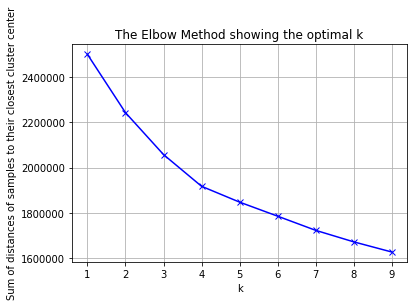

14:51:37


In [24]:
# no_of_records=364171
no_of_records=50000
print (format(datetime.now(), '%H:%M:%S'))
data = get_w2vdata(no_of_records)
X = run_classifier(data, vectorize_technique ='Otfidfw2v')
ist = datetime.now()
print (format(ist, '%H:%M:%S'))

In [25]:
csv_file_name = './amazon-fine-food-reviews/KMeansTfIdfWeightedW2V.csv'
optimal_k = 4
model = KMeans(n_clusters=optimal_k, n_jobs=-1).fit(X)
data['ClusterID']=model.labels_ 
data.to_csv(csv_file_name, index=False)

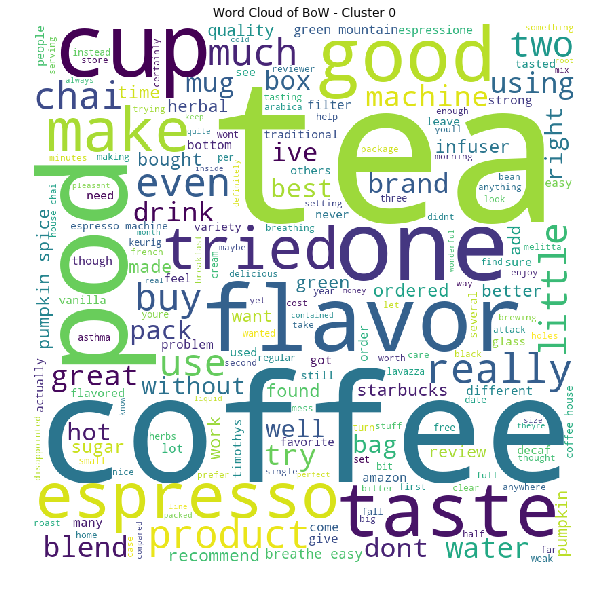

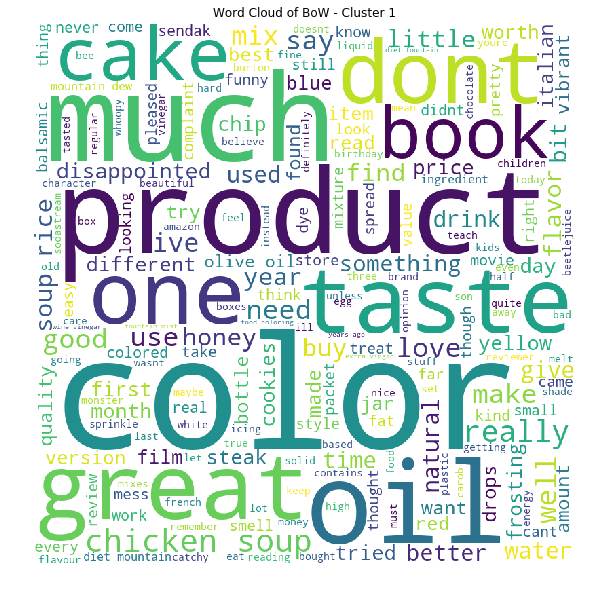

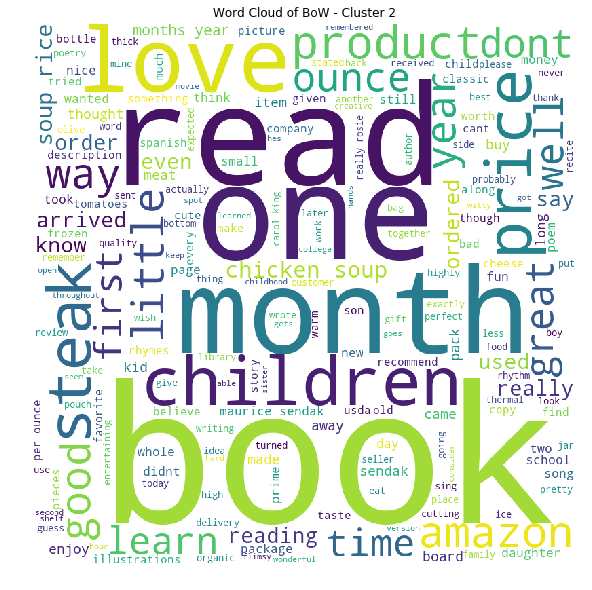

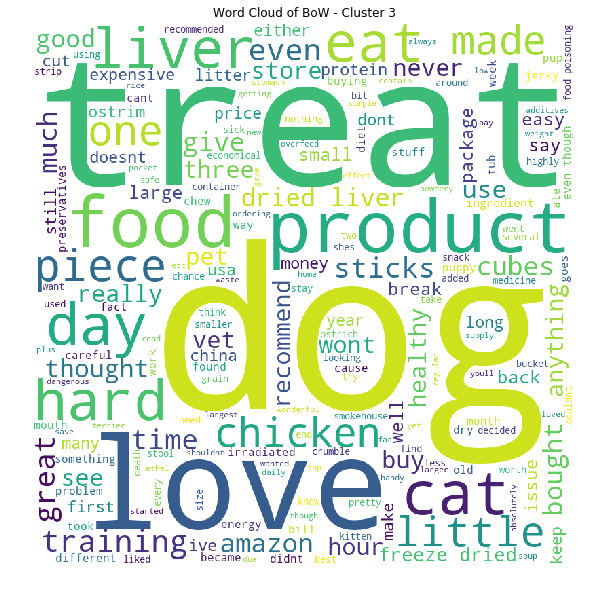

In [6]:
file_name='./amazon-fine-food-reviews/KMeansTfIdfWeightedW2V.csv'
title='Word Cloud of BoW - Cluster'
word_cloud_column = 'Word2VecText'
plot_word_cloud(file_name, title, word_cloud_column)

In [26]:
print (format(datetime.now(), '%H:%M:%S'))
metoid_file_name = './amazon-fine-food-reviews/MetoidsFromMetoids-TfIdfWtdW2V.csv'
clusters_file_name = './amazon-fine-food-reviews/ClusterFromMetoids-TfIdfWtdW2V.csv'
model_using_metoids(X, optimal_k, metoid_file_name, clusters_file_name)
print (format(datetime.now(), '%H:%M:%S'))

15:32:17
Creating pairwise distance.....
Clustering using KMedoids.....
Saving Metoids to file......
Saving Metoid Clusters to file......
16:03:56


### Pseudo-code
1. Get featurized data.
2. Vectorize data using techniques such as BoW, TFIDF, Average Word2Vec or TFIDF Weighted Average Word2Vec.
3. Run KMeans with a range of K values.
4. Plot the Ks to find the best K.
5. Use the best K to cluster using KMeans and KMedoids.

# Overall I feel that the clusters found by AverageW2V and TfIDFWeightedAverageW2V are better than clusters found by BagOfWords and TfIDF

## Bag of Words - Best K = 4
### KMeans


|Cluster|My Comments|
| -------------:|-------------:|
|0|This contains positive and 'you decide' kind of reviews. This mostly has lengthy reviews of movies, food and kids medicine.|
|1|Most of the reviews are short in this cluster. It contains almost equal amounts of positive and negative reviews. This contains reviews about kids books and dog food|
|2|This contains only 1 positive review about a movie. This movie's review was found in cluster 0 also. Since this review was not as lengthy as the ones in cluster 0 I think this was put in its own cluster.|
|3|This contains only 1 negative review about a food. This is short and contains some spelling mistakes.|

### Metoids
|Metoid|Reviews|
| -------------:|-------------:|
|0|If you are a fan of salmon roe this will hit the spot. A bit pricey.|
|1|Great!  Make it all of the time.|
|2|I have bought this brand several times and it's one of the worst cones I have tasted. It's tasteless and always broken. I normally eat everything organic but on this occasion I have to say there are some natural verities that have no hydrogenated oils that I rather buy.|
|3|I'm giving mine away. They are way too sweet. I'll stick with Mike and Ikes|

|Cluster|My Comments|
| -------------:|-------------:|
|0|Most of the reviews are about caviar.|
|1|Majority of the reviews are in this cluster. This is mostly like the cluster 1 of BoW. IT contains reviews about kids books and dog food.|
|2|This contains only negative reviews|
|3|Interesting. These contain reviews which either contain the word 'Mike' or 'Ike' or both.|


## TFIDF  - Best K = 2
### KMeans

|Cluster|My Comments|
| -------------:|-------------:|
|0|Most of the reviews are in this cluster. This contains reviews about kids books and dog food.|
|1|This contains a review about a hot sauce.|

### Metoids
|Metoid|Reviews|
| -------------:|-------------:|
|0|I have searched high and low to find a high-quality sugar free, dairy free chocolate bar that tasted just like the real thing, and I can honestly say that these amazing chocolate bars fit the bill perfectly!  Ross Chocolates has truly done it--I could not tell the difference between these and the kind made with sugar and dairy.  These dark chocolate bars are perfect for anyone looking for a pure, healthy alternative to the standard sugar-laden chocolate bar out there.  I am hypoglycemic, so normal sugary candy isn't an option for me.  These bars, though, have no impact on my blood sugar--in fact, I feel even better after eating them and have no negative reactions whatsoever!  They are also perfect for people who are allergic to dairy (like myself) because they are completely dairy-free.  As an added bonus, each bar contains 3 grams of fiber!  The bars have a wonderul, fresh crunch to them, with none of the strange aftertaste common to some products sweetened with sugar alcohols.  I honestly couldn't tell the difference between these maltitol-sweetened bars and those sweetened by regular sugar.  Enjoy!|
|1|they are excellent|

|Cluster|My Comments|
| -------------:|-------------:|
|0|This contains a review about chocolates.|
|1|This contains reviews about kids books and pet food.|


## AverageWord2Vec - Best K = 4
### KMeans

|Cluster|My Comments|
| -------------:|-------------:|
|0|Contains reviews about tea and coffee|
|1|This contains reviews about movies, kids books and baking products|
|2|This contains reviews about dog food, fishing bait and movie reviews|
|3|Mostly this cluster contains reviews about dog food.|

### Metoids
|Metoid|Reviews|
| -------------:|-------------:|
|0|I bought this to ship to me in Afghanistan, since it would be easier than asking my wife to go to the grocery store and then to the post office. Good price and fast shipping, but now I have to order a can opener. The item image depicts a pull-tab can which was my main concern, but the package that arrived did not have these tabs. If this is your concern, like mine, then don't buy.<br /><br />As for the taste or quality of the meat, well I'll just have to wait and see.|
|1|I'm not a tea drinker.  In fact up until the last week I would have said that I hated tea, in all its forms, hot, cold, sweetened, iced, etc.  But I'm bound and determined to make myself like tea because it's good for you and better than the soda I continually chug for the caffeine source.  So when I found Davidson's tea at a local market I decided to give it a try because the flavors sounded interesting and I didn't really have anything to lose.  And I'm so glad I did.  While I'd still rather be drinking a pepsi, this tea has made me realize that I may be able to convert myself.<br /><br />This particular flavor, Caramel Peach with Coconut, is considered a dessert tea and I figured that was the best place to start.  Something sweet to replace the cloying taste of a soda.  And this actually was pretty sweet.  I decided not to add any sweetener to the cup of tea as I figured that might be a bad habit to get into, so I just steeped this tea in boiling water for about five minutes, removed the tea bag, and started drinking.  And I was actually ok with the flavor and enjoyed sipping on it.  The most noticeable taste was the caramel.  It's what I really could taste aside from the bitterness of the tea itself.  I didn't so much taste the coconut, and only got a fair hint of the peach, but that was ok.  The taste was smooth and while there was that faint aftertaste of bitter tea that I don't really enjoy, it wasn't as bad as in some other teas I've tried.<br /><br />The ingredients were also very good in this tea.  Most of it was organic and used barley, chicory, chamomile, carob and rooibos and some natural flavors.  I was very pleased with the blend and it made me feel pretty healthy drinking it.  And it's not often you can find an organic tea at the reasonable price this is offered at either.  It was caffeine free, but that's just as well considering I used it at night while reading a book and getting ready for bed.  It made it all the more relaxing.<br /><br />As a beginner tea drinker I'd say this is very good.  It's the second of the brand that I've tried and both have been very palatable to me.  I look forward to drinking more of this flavor and branching out and trying others.<br /><br />Review by M. Reynard 2012|
|2|I'd keep these on hand for emergency food prep only, the exact situation we faced (snowed in, couldn't get to store). Luckily, we still had power during the snowstorm so we made the product as instructed.<br /><br />One tip here: remember that microwave ovens all cook at different temps and speeds, adjust cooking time accordingly. This should be gooey and not hard as a rock. We had two packages and had to test one before finding the right cooking time.<br /><br />The taste: Totally disappointing. While we all wanted a sweet treat, this barely met our needs, providing only calories and some energy, making me qualify it as suitable for "emergencies only". As far as providing a taste of sweetness, yes, this was fine. However, it fell far short of the "warm delight" promised by the cover photo and title. There was a decided hint of preservatives and some unpleasant flavors, creating an unsatisfactory culinary experience. No one expects a microwave mix to be high cuisine but this was barely palatable.<br /><br />We don't have gourmet standards by any means but this was not liked by anyone in the family, although the adults managed to eat our portions. The kids? Forget it.<br /><br />However, although I couldn't find them here, we DID try some mixes during the snowstorm that exceeded our expectations. One was Better Homes and Gardens Chocolate Chip mix. If you can find it, get it. It not only came in a lovely container but included the bonus of a year's subscription to BH & Gardens for only $5.00,  a bargain rate (optional, not required to subscribe to buy mix ). The mix in container cost $5.99 so we felt this was a better use of our money, leaving us with a reusable and microwavable container and tasty cookies for the $5.99. If we wanted, we had a monthly  magazine for another $5.00. You do the math and conduct a taste test and I think you'll agree that "warm delights" aren't so delightful. Just a thought.|
|3|We absolutely love the Buster Cube, as does our dog Jack!  This is easily our favorite toy of his, and arguably the second best item we've bought for him (his crate being #1).<br /><br />When we first got the Buster Cube, it distracted him for 30 minutes at a time.  Not only does it challenge his mind, but it forces him to eat slower so he digests better.  We pretty much put his entire dinner in there now!<br /><br />He loves the cube as well, and views it as a treat now, in and of itself!  (i.e. He'll "beg" for it, and even roll it around when there's no treats in it.)<br /><br />Since then he's gotten much faster at getting the food out, so we have been slowly dialing up the difficulty.  (There is a dial that increases/decreases the food reservoir.)<br /><br />Some tips:  It's really noisy if your dog plays with it on tiling, and it slides around more than it rolls.  So if the noise bothers you or if you want to make it easier for your dog, have hir play with it on carpeting.<br /><br />Also, it helps to play with it in an area where the cube won't accidentally roll underneath dressers or down the stairs or get wedged into a corner.  (Although, through these kinds of mistakes, Jack has figured out how to avoid them.)<br /><br />The most important thing, as mentioned in the included instructions, is to make make sure your dog quickly gets food out of it and realizes there's more to be had. Even the very first time we tried the Buster Cube, Jack was completely focused and involved. :)<br /><br />Update:<br /><br />We've had this over a month now, and now the full-size Buster Cube is our favorite -- our dog outgrew the mini as his meals got bigger and it took longer and longer for us to pack them into the mini.<br /><br />If we ever got another puppy, I'd also use the small-sized Cube in between the mini and the large.  The Cubes are awesome, but let them grow with your pet. :)|

|Cluster|My Comments|
| -------------:|-------------:|
|0|This mostly contains short reviews about different stuff.|
|1|These reviews are about coffee and tea|
|2|This contains a mix of reviews about kids books, cooking books and cookies|
|3|This contains mostly about pet foods.|


## TFIDFWeightedWord2Vec - Best K = 4
### KMeans

|Cluster|My Comments|
| -------------:|-------------:|
|0|This contains reviews about coffee and tea.|
|1|These contain reviews about food coloring, nutritional bars and ice cream|
|2|These contain reviews about books and movies.|
|3|These contain mostly about pet food|

### Metoids
|Metoid|Reviews|
| -------------:|-------------:|
|0|I have been struggling wth quitting coffee and this has been just the thing to get me off of coffee once and for all. The spearmint flavor really comes thru at just the perfect intensity to make this one of my favorites. This is also a great green tea to try if you are struggling with the taste of plain green tea, which I was. ;)|
|1|Having bought various types of vinegars hoping to find the right one but never did until now.  My local hyper market sells various brands of balsamic but some have a heft price tag, the more aged typically the more it cost.  Honestly have bought some cheap ones but got a glorified bottle of plain vinegar or was un-naturally sweet.  Made a pot of my homemade(from scratch)pasta sauce, while it's also been really good 2 tsp of Alessi made it great.  Can't believe the taste it gives to a tomatoe based sauce, was eating by the spoonfuls before adding to the pasta.  Wanting to experiment some more, I have been wanting to make some roasted red pepper remoulade to jazz up a BLT or Roast Beef sandwhich.  This was the key ingredient even more so than the roasted red peppers.  The balsamic cut the fatty taste of the mayo(not a fan of may alone except potato/pasta salad)and added an interesting sweetness but not like sugar.  Ate couple spoons of that as well.  Not to worry I am not a double dipper even in my own house.  I think this will wake up a roast beef gravy and who knows what else.  Now I know what to buy and can also afford.|
|2|I am a very novice cake decorator but have some artistic skills so fondant has been fun for me and I had plenty of practice with this stuff before I tried this package, but I have no means an expert opinion. The colors were vibrant and the quantity in the package was ample. This stuff was not as plyable and did not taste quite as good as the other celebrity cake decorator brand one I had used in the past. Where it was stronger was in longevity, it stayed pliable longer and when I went to reuse it, it had stored better. No store bought fondant is super tasty and this stuff is edible but not very desirable.|
|3|(I wonder if anyone else has seen the"Saturday Night Live" sketch about a convention of pirates whose discourse is limited to the"arrrgh" sound.)  This product tastes like alfalfa/barley juice, except the popcorn texture makes it difficult to make the taste go away simply by holding your nose.  As for all the health benefits, the veggies indeed impart "flavor" to this mish-mash, a bag of which equals 8 grams of protein plus nearly 600 calories, but what do the veggies contribute and what percentage of the product do they represent?  Unless I notice some dramatic health benefits, I'm going to have trouble disposing of 12 bags (Lesson: Even though Amazon limits you to large quantities, don't order 12 bags if you haven't first tried one).  The only way I can consume this stuff is to wash down every bite with a mouthful of cold Coke.  Or, picking up on the company's pirate theme, Coke laced with a lot of rum.  Unassisted by such complementary beverages, I'm afraid this booty elicits no pirate's celebratory "Arrrgh!" from me.  Just plain "Yuck!" is more like it.|


|Cluster|My Comments|
| -------------:|-------------:|
|0|These contain reviews about coffee and tea|
|1|The majority of the reviews are about food.|
|2|These contain reviews about movies mostly and I did notice a few reviews about dog food and movies|
|3|Most of the reviews are about dog food|